In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import LineString, Point

In [92]:
def createrandomp(n):
    

    p=[]
    for i in range(n):
        while True:
            a=np.random.random()
            b=np.random.random()

            if not((a,b) in p):
                p.append((a,b))
                break
    return p

def plot(p):
    x=[i[0] for i in p]
    y=[i[1] for i in p]
    n= [i for i in range (len(p))]
    fig, ax = plt.subplots()
    ax.scatter(x, y)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]))
def dist(p,i,j):
    return (((p[i][0]-p[j][0])**2)+((p[i][1]-p[j][1])**2))**0.5
def len_ord(p):
    l=[]
    orders=[]
    
    for i in range (len(p)):
        for j in range(i+1,len(p)):
            orders.append((i,j))
            l.append(dist(p,i,j))
    return l,orders

def intersect (p , i , j, k, l):
    
    A = p[i]
    B = p[j]

    #line 2
    C = p[k]
    D = p[l]

    line1 = LineString([A, B])
    line2 = LineString([C, D])

    int_pt = line1.intersection(line2)

    if int_pt.is_empty: 
        #print('empty')
        return False
    if type(int_pt)==shapely.geometry.linestring.LineString: 
        #print('line',int_pt)
        return True
    elif type(int_pt)==shapely.geometry.point.Point:
        point_of_intersection = int_pt.x, int_pt.y
        
        #print('point')
  
        if point_of_intersection in (A,B,C,D): 
            
            if len((A,B,C,D))==len(set((A,B,C,D))): return True
            else: return False

        else: return True
    
def matrixA(p,phi):
    l,orders=len_ord(p)
    #print('orders:', orders)
    #print(l)
    #phi1=min(l)
    #phi2=phi1
    #print(phi)
    #print('phi of amatrix:',phi)
    a=np.array (l)
    #print('phi of amatrix:',phi)
    a=np.diag(a)
    for i in range (len(p)):
        for j in range (len(p)):
            if j!=i:
                for k in range(len(p)):
                    for l in range(len(p)):
                        if k!=l:
                            #print(i,j,k,l)
                            if len(set((i,j,k,l)))>2:
                                if intersect(p,i,j,k,l):
                                    #print('done')
                                    a[orders.index((min(i,j),max(i,j))),orders.index((min(k,l),max(k,l)))]=phi
                                    a[orders.index((min(k,l),max(k,l))),orders.index((min(i,j),max(i,j)))]=phi
    
    
    d= np.linalg.eigvals(a)
    #print('d:',d)  

    return a
def matrixC(p):
    l, orders = len_ord(p)
    c= np.zeros([len(p), len(l)])
    for x in orders:
        c[x[0],orders.index(x)]=1
        c[x[1],orders.index(x)]=1
    return c
def vectorb(p):
    n=len(p)
    return [2]*n    
def custompath(p,path):
    d=0
    for i in range(0,len(path)):
        d+=dist(p,i,i-1)
    return d

In [93]:
def lag(p):
    l,orders= len_ord(p)
    phi=(sum(l)+10)**(len(p))
   
    #print('phi of result',phi)
    a=matrixA(p,phi)
    #print(a)
    c=matrixC(p)
    b=vectorb(p)
    
    L=np.zeros(len(l)+len(p))

    d=np.diag(np.diag(a))
    a=a+d
    c0=np.zeros([len(p),len(p)])
    #print('//////////////////////////')
    #print(a)
    #print(c)
    #print(a.shape)
    #print((c.T).shape)
    #print(c0)
    L=np.bmat([[a, -c.T], [np.matrix(c),np.matrix(c0)]])
    #print((L/10000).round(1))
    L=np.array(L)
    return L
def lagb(p):
    l,orders= len_ord(p)
    phi=(sum(l)+10)**(len(p))
    b=[phi]*len(l)+[2]*len(p)
    return np.array(b)


In [131]:
def chosen(p,x):
    l,orders=len_ord(p)
    phi=(sum(l)+10)**(len(p))
    error=1/phi
    chosen=[]

    for i in range(len(x)):
        if x[i]>1 or abs(x[i]-1)<error:
            
            chosen.append(i)
        
    return chosen
def rejected(p,x):
    l,orders=len_ord(p)
    phi=(sum(l)+10)**(len(p))
    error=1/phi
    rejected=[]

    for i in range(len(x)):
        if x[i]<0 or abs(x[i])<error:
            rejected.append(i)

    return rejected
def gay(p,x):
    l,orders=len_ord(p)
    phi=(sum(l)+10)**(len(p))
    error=1/phi
    gay=[]
    for i in range(len(x)):
        if x[i]>1 or abs(x[i]-1)<error:
            pass
        elif x[i]<0 or abs(x[i])<error:
            pass
        else:
            gay.append(i)
    return gay


In [142]:
def chosenactivation(p,L,b,chosennum):
    l,orders=len_ord(p)
    phi=(sum(l)+10)**(len(p))
    
    for k in range (len(l),len(L)):
        
        if L[k,chosennum]==1:
            actifcond=L[k,:]
            for pt1 in range(len(actifcond)):
                for pt2 in range(pt1+1,len(actifcond)):
                    if pt1!=chosennum and pt2!=chosennum:
                        if actifcond[pt1]==1 and actifcond[pt2]==1:
                            L[pt1,pt2]=phi
                            L [pt2,pt1]=phi
                            
                            
    c=np.zeros([1,len(L)])
    #print(c)
    c[0,chosennum]=phi
    #print(c)
    #print('//////////////////////////')
    #print(a)
    #print(c)
    #print(a.shape)
    #print((c.T).shape)
    #print(c0)
    L=np.bmat([[L, -c.T], [np.matrix(c),np.matrix([[0]])]])
    b=np.append(b, np.array([phi]), axis=0)
    
    return L,b


def rejectedactivation(p,L,b,rejectednum):
    l,orders=len_ord(p)
    phi=(sum(l)+10)**(len(p))
    #L[rejectednum,rejectednum]=phi
    c=np.zeros([1,len(L)])
    #print(c)
    c[0,rejectednum]=phi
    #print(c)
    #print('//////////////////////////')
    #print(a)
    #print(c)
    #print(a.shape)
    #print((c.T).shape)
    #print(c0)
    L=np.bmat([[L, -c.T], [np.matrix(c),np.matrix([[0]])]])
    b=np.append(b, np.array([0]), axis=0)
        
    return L,b



In [165]:
def result(p,L,b):


    l,orders= len_ord(p)
    phi=(sum(l)+10)**(len(p))
   
    #print('phi of result',phi)
    
    x=np.linalg.solve(L,b)
 
    x=x[:len(l)]
    return x
def artificialmodel(p):
    l,orders=len_ord(p)
    L,b=lag(p), lagb(p)
    
    x=result(p,L,b)
    iteration=0
    print(x)
    oldgay=gay(p,x)
    gaytest=False
    chosenforever=[]
    rejectedforever=[]
    while gay(p,x)!=[]:
        oldgay=gay(p,x)
        print(iteration)
        choose=chosen(p,x)
        reject=rejected(p,x)
        print('chose',choose,'reject',reject)
        print(gaytest)
        print('oldgay',oldgay)
        if (choose==[] and reject==[]) or gaytest:
            print('bad model')
            maxgay=0
            mingay=1
            for i in oldgay:
                if x[i]<mingay:
                    mingay=x[i]
                    reject=[i]
                if x[i]>maxgay:
                    maxgay=x[i]
                    choose=[i]

            gaytest=False
            print(choose,reject)
        if len(choose)>=len(p):
            choose=[]
            print('choose deleted')
        if len (reject)>=len(l)-len(p):
            reject=[]
            print('reject deleted')
        for i in choose:
            if not(i in chosenforever):
                L,b=chosenactivation(p,L,b,i)
        for i in reject:
            if not (i in rejectedforever):
                L,b=rejectedactivation(p,L,b,i)
        x=result(p,L,b)
        print(x)
        iteration+=1
        newgay=gay(p,x)
        gaytest=oldgay==newgay
        
        chosenforever+=choose
        rejectedforever+=reject
        print('choose + forever',chosenforever)
        #chosenforever=list(set(chosenforever))
        #chosenforever=list(set(reject+rejectedforever))
        print('forever choesen',chosenforever)
        print('for ever rejected',rejectedforever)
    return x
        
def sortedp(p,x):
    l,orders=len_ord(p)
    print(orders)
    for i in range (len(x)):
        for j in range (i+1,len(x)):
            if x[i]<x[j]:
                x[i],x[j]=x[j],x[i]
                orders[i],orders[j]=orders[j],orders[i]
    print(orders)
    return orders[:len(p)]
            
def printpath(p):
    newp=sortedp(p)
    x=[i[0] for i in newp]
    y=[i[1] for i in newp]
    #plt.plot(x,y)
    #plt.plot(x, y, 'ro', 'k')
    plt.plot(x, y, 'r', zorder=1, lw=3)
    plt.scatter(x, y, s=120, zorder=2)      
def readablex(p,x):
    l,orders=len_ord(p)
    for i in range (len(l)):
        print(i,orders[i],x[i])

0 (0, 1) 0.8796622765322166
1 (0, 2) 1.1203368209252824
2 (0, 3) 1.6447422981463654e-06
3 (0, 4) -7.421997970750976e-07
4 (1, 2) 1.5522252300669084e-06
5 (1, 3) 0.12033588575830345
6 (1, 4) 1.0000002854600591
7 (2, 3) 0.8796618197265161
8 (2, 4) -1.9309997131887535e-07
9 (3, 4) 1.0000006497991414


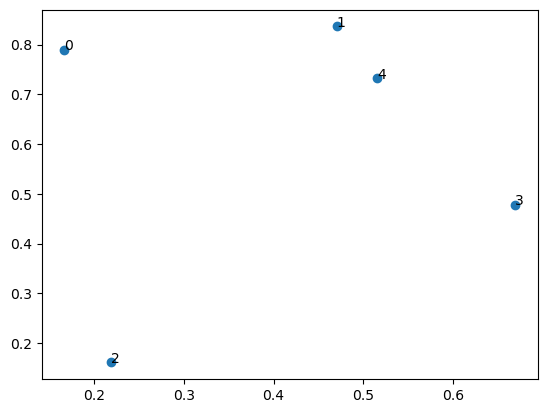

In [101]:
n=6
#p=createrandomp(n)
p=[(0.16664691325935033, 0.7890471389301101),
 (0.4704527326880199, 0.8364449291888473),
 (0.2183248603322735, 0.16115590925871437),
 (0.6694307938668275, 0.47760888112337796),
 (0.515724455034698, 0.7319801512308717)]
l,orders=len_ord(p)
L,b=lag(p), lagb(p)
x=result(p,L,b)
for i in range (len(l)):
    print(i,orders[i],x[i])
plot(p)


In [74]:
chosen(p,x)

[1, 6, 9]

In [75]:
rejected(p,x)

[3, 8]

In [76]:
gay(p,x)

[0, 2, 4, 5, 7]

In [78]:
((L)).round(0)

array([[ 1.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00, -1.00000e+00, -1.00000e+00,
        -0.00000e+00, -0.00000e+00, -0.00000e+00],
       [ 0.00000e+00,  1.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00, -1.00000e+00, -0.00000e+00,
        -1.00000e+00, -0.00000e+00, -0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  1.00000e+00,  0.00000e+00,
         6.67827e+05,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         6.67827e+05,  0.00000e+00, -1.00000e+00, -0.00000e+00,
        -0.00000e+00, -1.00000e+00, -0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00,
         6.67827e+05,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00, -1.00000e+00, -0.00000e+00,
        -0.00000e+00, -0.00000e+00, -1.00000e+00],
       [ 0.00000e+00,  0.000

In [79]:
(rejectedactivation(p,L,1)/10000).round(0)

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00,  4.4599281e+07,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         6.7000000e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         6.7000000e+01,  0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         6.7000000e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+0

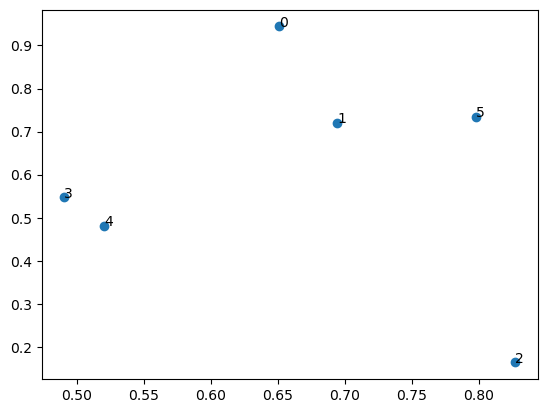

In [104]:
plot(p)

In [103]:
artificialmodel(p)

[ 2.00000074e+00  2.26991341e-07 -4.68856696e-07  2.26991344e-07
 -7.25407467e-07 -1.43149348e-07 -2.26991382e-07 -1.43149350e-07
 -2.26991397e-07 -6.51535837e-08 -7.66647489e-07  2.00000075e+00
  2.00000062e+00  1.43149344e-07  6.51535473e-08]
0
[0, 11, 12] [2, 4, 5, 6, 7, 8, 9, 10, 14]
False
[ 1.          0.5558841  -0.05553304  0.55538292 -0.05573398  0.27781676
  0.22228371  0.27781676  0.22208276  0.05573406  0.11126719  0.99876504
  1.          0.77751527  0.05553312]
1
[0, 12] [2, 4]
False
[ 1.17335600e+00  2.43735613e-01 -6.65079223e-02  6.49416253e-01
  5.82236684e-08  2.66627055e-01  2.00119089e-01  2.66627024e-01
  2.66627096e-01  3.62787099e-08  6.65080488e-02  7.49928890e-01
  9.50940666e-01  9.15448132e-01  6.65080082e-02]
2
[0] [2, 4, 9]
False
[ 1.17335600e+00  2.43735613e-01 -6.65079223e-02  6.49416253e-01
  5.82236684e-08  2.66627055e-01  2.00119089e-01  2.66627024e-01
  2.66627096e-01  3.62787099e-08  6.65080488e-02  7.49928890e-01
  9.50940666e-01  9.15448132e-01  6.

LinAlgError: Singular matrix

[ 2.00000018e+00  3.97476816e-08 -7.19317892e-10 -1.54835423e-07
 -6.22630328e-08  7.19314851e-10 -2.03657422e-07  6.22630271e-08
 -3.97476825e-08  2.00000019e+00 -1.65973483e-07 -6.22630322e-08
  6.22630272e-08 -3.97476831e-08  2.00000020e+00]
0
chose [0, 9, 14] reject [2, 3, 4, 5, 6, 8, 10, 11, 13]
False
oldgay [1, 7, 12]
reject deleted
[ 1.00000000e+00 -2.99999940e+00  2.49999973e+00 -1.13320998e-07
  1.49999978e+00 -1.49999972e+00  2.99999937e+00 -4.99999760e-01
  1.08781506e-07  1.00000000e+00  3.49999951e+00  1.99999963e+00
 -1.99999959e+00 -2.49999952e+00  1.00000000e+00]
choose + forever [0, 9, 14]
forever choesen [0, 9, 14]
for ever rejected []
1
chose [0, 2, 4, 6, 9, 10, 11, 14] reject [1, 3, 5, 7, 12, 13]
False
oldgay [8]
choose deleted
[ 1.00000000e+00 -1.37917481e-15  1.00000002e+00  3.40195293e-16
 -2.12362697e-08  1.13398355e-16 -2.12362694e-08  4.23555454e-16
  1.00000002e+00  1.00000000e+00  9.99999996e-01 -2.18405416e-15
  0.00000000e+00  0.00000000e+00  1.00000000e+0

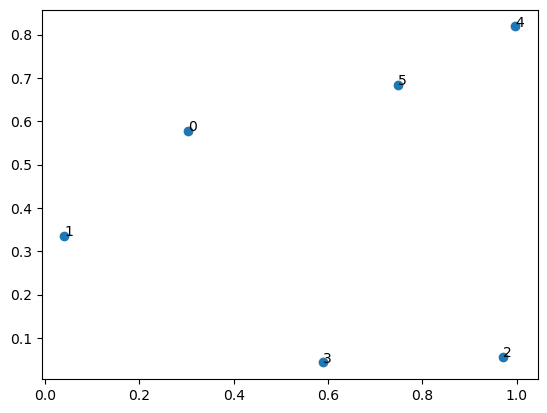

In [168]:
n=6
p=createrandomp(n)


x=artificialmodel(p)
print(readablex(p,x))

sortedp(p,x)
plot(p)


In [171]:
p=[(0.3038504438091757, 0.5784637729944366),
 (0.040963386390709955, 0.33543155513656),
 (0.9715468315224746, 0.05613193146054163),
 (0.5901113620142922, 0.04349217878305167),
 (0.9971858890955796, 0.8188342821806295),
 (0.7478607657281613, 0.6848351757992676)]



x=artificialmodel(p)
print(readablex(p,x))

sortedp(p,x)
plot(p)

custompath(p,[0,1,3,2,4,5])- custompath(p,[0,3,2,4,5,1])#mine#mine/his


0.0

In [36]:
custompath(p,[0,1,3,4,2])#mine

2.3240013060699245

In [37]:
custompath(p,[0,2,1,3,4])#algo

2.3240013060699245

In [38]:
custompath(p,[0,2,1,3,4])-custompath(p,[0,1,3,4,2])

0.0

In [164]:
l=[1,2,3,4,862,3,2,1,2,3,0,0,0]
set(l)

{0, 1, 2, 3, 4, 862}

# methical test case

In [ ]:
p=[(0.3038504438091757, 0.5784637729944366),
 (0.040963386390709955, 0.33543155513656),
 (0.9715468315224746, 0.05613193146054163),
 (0.5901113620142922, 0.04349217878305167),
 (0.9971858890955796, 0.8188342821806295),
 (0.7478607657281613, 0.6848351757992676)]
custompath(p,[0,1,3,2,4,5])- custompath(p,[0,3,2,4,5,1])#mine#mine/his
x=artificialmodel(p)
print(readablex(p,x))

sortedp(p,x)
plot(p)
#this test case gives a result that looks intuitively wrong(intersecting) but it is exactly as long as the obvious sol(none intersecting)
#conclusion: the none intersection is neither essential nor suffcient
#an intersecting path can be optimum
# a none intersecting path can be a bad
#this kinda destroys my first postula, need to think about it.